# Regression showdown

In [1]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial
from typing import Callable
from tqdm.notebook import tqdm
from rebayes.utils import datasets
from jax.flatten_util import ravel_pytree

from rebayes import base
from rebayes.extended_kalman_filter import ekf
from rebayes.low_rank_filter import lofi

In [2]:
import hparam_tune_ekf as hp_ekf
import hparam_tune_lofi as hp_lofi

In [3]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

In [4]:
plt.rcParams["font.size"] = 12
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["legend.fontsize"] = 12
plt.rcParams["lines.linewidth"] = 2

In [5]:
# dataset = "wine"
# train, test = datasets.load_uci_wine_regression()

# dataset = "power"
# train, test = datasets.load_uci_power()

dataset = "kin8nm"
train, test = datasets.load_uci_kin8nm()

# dataset = "naval"
# train, test = datasets.load_uci_naval()

# dataset = "rmnist_0_5"
# train, test = datasets.load_rotated_mnist(frac_train=0.8, num_train=None, target_digit=[1, 2, 3, 4, 5])

In [6]:
# train, test = datasets.load_1d_synthetic_dataset(5_000, 1_000, sort_data=False)
(X_train, y_train) = train
(X_test, y_test) = test

y_train = y_train.ravel()
y_test = y_test.ravel()

In [7]:
def rmae_callback(bel, *args, **kwargs):
    X_test, y_test = kwargs["X_test"], kwargs["y_test"]
    apply_fn = kwargs["apply_fn"]
    
    yhat = apply_fn(bel.mean, X_test).squeeze()
    err = jnp.abs(y_test - yhat.ravel())
    
    res = {
        "test": err.mean(),
    }
    return res

In [8]:
def eval_callback(bel, pred, t, X, y, **kwargs):
    X_test, y_test = kwargs["X_test"], kwargs["y_test"]
    apply_fn = kwargs["apply_fn"]
    
    yhat = apply_fn(bel.mean, X_test).squeeze()
    err_test = jnp.abs(y_test - yhat.ravel())
    
    # One-step-ahead absolute error
    err = jnp.abs(y.ravel() - pred.mean.ravel()).sum()
    
    
    res = {
        "test": err_test.mean(),
        "osa-error": err,
    }
    return res

## Test setup

In [9]:
key = jax.random.PRNGKey(3141)

In [10]:
n_warmup = 1000

X_warmup = X_train[:n_warmup]
y_warmup = y_train[:n_warmup]

X_learn = X_train[n_warmup:]
y_learn = y_train[n_warmup:]

warmup_train = (X_warmup[:-100], y_warmup[:-100])
warmup_test = (X_warmup[-100:], y_warmup[-100:])

In [36]:
pbounds = {
    "log_init_cov": (-5, 0.0),
    "dynamics_weights": (0, 1.0),
    "log_emission_cov": (-7, 0.0),
    "log_dynamics_cov": (-7, 0.0),
}


In [97]:
probe_points = {
    "dynamic_weights": np.array([0.0, 0.5, 1.0]), # gamma
    "log_init_cov": np.log([0.01, 0.1, 1.0]), # eta
    "log_emission_cov": np.log([0.01, 0.1, 1.0]) # R
}

probe_points = pd.DataFrame(probe_points)



def eval_steady(log_g, log_eta):
    """
    For dynamic's cov
    """
    g = np.exp(log_g)
    
    eta = np.exp(v["log_init_cov"])
    q = (1 - g ** 2) / eta
    return np.log(q)

jax.tree_map(lambda x: x.shape, probe_points)

(3, 3)

## Model setup

In [15]:
class MLP(nn.Module):
    n_out: int
    activation: Callable = nn.relu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(20)(x)
        x = self.activation(x)
        x = nn.Dense(20)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_out)(x)
        return x
    
dim_out = 1
_, dim_in = X_train.shape
model = MLP(dim_out, activation=nn.elu)

In [16]:
params = model.init(key, jnp.ones((1, dim_in)))
flat_params, _ = ravel_pytree(params)
n_params = len(flat_params)

# Agent showdown

## Diag-EKF

In [37]:
optimizer, apply_fn, n_feats = hp_ekf.create_optimizer(
    model, pbounds, 314, warmup_train, warmup_test, rmae_callback
)

In [38]:
%%time
optimizer.maximize(
    init_points=10,
    n_iter=15,
)

|   iter    |  target   | dynami... | log_dy... | log_em... | log_in... |
-------------------------------------------------------------------------
| 1         | -0.8794   | 0.9169    | -2.88     | -5.145    | -1.084    |
| 2         | -0.8777   | 0.918     | -1.209    | -1.904    | -3.698    |
| 3         | -0.8728   | 0.9118    | -5.175    | -1.635    | -3.692    |
| 4         | -0.8691   | 0.1223    | -4.298    | -1.119    | -3.609    |
| 5         | -0.8709   | 0.06991   | -2.568    | -2.907    | -2.094    |
| 6         | -0.8749   | 0.6772    | -2.19     | -3.928    | -3.395    |
| 7         | -0.8708   | 0.5706    | -3.641    | -0.9725   | -0.826    |
| 8         | -0.8689   | 0.1058    | -6.577    | -2.822    | -1.038    |
| 9         | -0.8722   | 0.2264    | -3.254    | -6.048    | -3.139    |
| 10        | -0.8693   | 0.152     | -3.991    | -1.451    | -2.965    |
| 11        | -0.8689   | 0.0       | -5.413    | -1.716    | -1.346    |
| 12        | -0.8688   | 0.0       | 

In [39]:
test_kwargs = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn}

hparams = hp_ekf.get_best_params(n_params, optimizer, method="fdekf")
dekf_estimator = hp_ekf.build_estimator(flat_params, hparams, None, apply_fn, method="fdekf")
bel_dekf, output_dekf = dekf_estimator.scan(
    X_learn, y_learn, callback=eval_callback, progress_bar=False, **test_kwargs
)

## LoFi

In [40]:
method = "orth_svd_lofi"
params_lofi = lofi.LoFiParams(
    memory_size=50,
    sv_threshold=0.0,
    adaptive_variance=False,
)


optimizer, apply_fn, n_features = hp_lofi.create_optimizer(
    model, pbounds, 314, warmup_train, warmup_test, params_lofi, rmae_callback, method=method
)

In [41]:
%%time
optimizer.maximize(
    init_points=10,
    n_iter=15,
)

|   iter    |  target   | dynami... | log_dy... | log_em... | log_in... |
-------------------------------------------------------------------------
| 1         | -0.8724   | 0.9169    | -2.88     | -5.145    | -1.084    |
| 2         | -0.8723   | 0.918     | -1.209    | -1.904    | -3.698    |
| 3         | -0.8659   | 0.9118    | -5.175    | -1.635    | -3.692    |
| 4         | -0.8693   | 0.1223    | -4.298    | -1.119    | -3.609    |
| 5         | -0.8713   | 0.06991   | -2.568    | -2.907    | -2.094    |
| 6         | -0.881    | 0.6772    | -2.19     | -3.928    | -3.395    |
| 7         | -0.8772   | 0.5706    | -3.641    | -0.9725   | -0.826    |
| 8         | -0.8719   | 0.1058    | -6.577    | -2.822    | -1.038    |
| 9         | -0.8722   | 0.2264    | -3.254    | -6.048    | -3.139    |
| 10        | -0.87     | 0.152     | -3.991    | -1.451    | -2.965    |
| 11        | -0.8699   | 0.1349    | -5.501    | -2.009    | -3.487    |
| 12        | -0.6086   | 1.0       | 

In [42]:
test_kwargs = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn}

hparams = hp_lofi.get_best_params(n_params, optimizer)
lofi_estimator = hp_lofi.build_estimator(flat_params, hparams, params_lofi, apply_fn, method=method)
bel_lofi, output_lofi = lofi_estimator.scan(
    X_learn, y_learn, callback=eval_callback, progress_bar=False, **test_kwargs
)

## LoFi (orth / adapted)

In [43]:
method = "orth_svd_lofi"
params_lofi = lofi.LoFiParams(
    memory_size=50,
    sv_threshold=0.0,
    adaptive_variance=True,
)

optimizer, apply_fn, n_features = hp_lofi.create_optimizer(
    model, pbounds, 314, warmup_train, warmup_test, params_lofi, rmae_callback, method=method
)

In [44]:
%%time
optimizer.maximize(
    init_points=10,
    n_iter=15,
)

|   iter    |  target   | dynami... | log_dy... | log_em... | log_in... |
-------------------------------------------------------------------------
| 1         | -0.8809   | 0.9169    | -2.88     | -5.145    | -1.084    |
| 2         | -0.8689   | 0.918     | -1.209    | -1.904    | -3.698    |
| 3         | -0.8734   | 0.9118    | -5.175    | -1.635    | -3.692    |
| 4         | -0.869    | 0.1223    | -4.298    | -1.119    | -3.609    |
| 5         | -0.8693   | 0.06991   | -2.568    | -2.907    | -2.094    |
| 6         | -0.8694   | 0.6772    | -2.19     | -3.928    | -3.395    |
| 7         | -0.8737   | 0.5706    | -3.641    | -0.9725   | -0.826    |
| 8         | -0.8701   | 0.1058    | -6.577    | -2.822    | -1.038    |
| 9         | -0.8692   | 0.2264    | -3.254    | -6.048    | -3.139    |
| 10        | -0.8692   | 0.152     | -3.991    | -1.451    | -2.965    |
| 11        | -0.8692   | 0.3453    | -2.516    | -2.281    | -3.459    |
| 12        | -0.8689   | 0.0       | 

In [45]:
test_kwargs = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn}

hparams = hp_lofi.get_best_params(n_params, optimizer)
lofi_aov_estimator = hp_lofi.build_estimator(flat_params, hparams, params_lofi, apply_fn, method=method)
bel_lofi_aov, output_lofi_aov = lofi_aov_estimator.scan(
    X_learn, y_learn, callback=eval_callback, progress_bar=False, **test_kwargs
)

## LoFi (full / fixed)

In [46]:
method = "full_svd_lofi"
params_lofi = lofi.LoFiParams(
    memory_size=50,
    sv_threshold=0.0,
    adaptive_variance=False
)

optimizer, apply_fn, n_features = hp_lofi.create_optimizer(
    model, pbounds, 314, warmup_train, warmup_test, params_lofi, rmae_callback, method=method
)

In [47]:
%%time
optimizer.maximize(
    init_points=10,
    n_iter=15,
)

|   iter    |  target   | dynami... | log_dy... | log_em... | log_in... |
-------------------------------------------------------------------------
| 1         | -0.9074   | 0.9169    | -2.88     | -5.145    | -1.084    |
| 2         | -0.8726   | 0.918     | -1.209    | -1.904    | -3.698    |
| 3         | -0.8719   | 0.9118    | -5.175    | -1.635    | -3.692    |
| 4         | -0.8693   | 0.1223    | -4.298    | -1.119    | -3.609    |
| 5         | -0.8713   | 0.06991   | -2.568    | -2.907    | -2.094    |
| 6         | -0.8814   | 0.6772    | -2.19     | -3.928    | -3.395    |
| 7         | -0.8781   | 0.5706    | -3.641    | -0.9725   | -0.826    |
| 8         | -0.8719   | 0.1058    | -6.577    | -2.822    | -1.038    |
| 9         | -0.8722   | 0.2264    | -3.254    | -6.048    | -3.139    |
| 10        | -0.87     | 0.152     | -3.991    | -1.451    | -2.965    |
| 11        | -0.8689   | 0.0       | -2.47     | -0.4706   | -3.656    |
| 12        | -0.8716   | 0.0       | 

In [48]:
test_kwargs = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn}

hparams = hp_lofi.get_best_params(n_params, optimizer)
lofi_fsvd_estimator = hp_lofi.build_estimator(flat_params, hparams, params_lofi, apply_fn, method=method)
bel_lofi_fsvd, output_lofi_fsvd = lofi_fsvd_estimator.scan(
    X_learn, y_learn, callback=eval_callback, progress_bar=False, **test_kwargs
)

## ORFit

In [49]:
method = "orfit"
params_orfit = base.RebayesParams(
    initial_mean=flat_params,
    emission_mean_function=apply_fn,
    **hparams
)
orfit_estimator = lofi.RebayesLoFi(params_orfit, params_lofi, method=method)
bel_orfit, output_orfit = orfit_estimator.scan(
    X_learn, y_learn, callback=eval_callback, progress_bar=False, **test_kwargs
)

## FC-EKF

In [50]:
optimizer, apply_fn, n_features = hp_ekf.create_optimizer(
    model, pbounds, 314, warmup_train, warmup_test, rmae_callback, method="fcekf"
)

In [51]:
%%time
optimizer.maximize(
    init_points=10,
    n_iter=15,
)

|   iter    |  target   | dynami... | log_dy... | log_em... | log_in... |
-------------------------------------------------------------------------
| 1         | -0.8754   | 0.9169    | -2.88     | -5.145    | -1.084    |
| 2         | -0.9105   | 0.918     | -1.209    | -1.904    | -3.698    |
| 3         | -0.8728   | 0.9118    | -5.175    | -1.635    | -3.692    |
| 4         | -0.8691   | 0.1223    | -4.298    | -1.119    | -3.609    |
| 5         | -0.8709   | 0.06991   | -2.568    | -2.907    | -2.094    |
| 6         | -0.8749   | 0.6772    | -2.19     | -3.928    | -3.395    |
| 7         | -0.8708   | 0.5706    | -3.641    | -0.9725   | -0.826    |
| 8         | -0.8689   | 0.1058    | -6.577    | -2.822    | -1.038    |
| 9         | -0.8722   | 0.2264    | -3.254    | -6.048    | -3.139    |
| 10        | -0.8693   | 0.152     | -3.991    | -1.451    | -2.965    |
| 11        | -0.8696   | 0.0       | -4.724    | -3.744    | -2.323    |
| 12        | -0.8688   | 0.0       | 

In [52]:
test_kwargs = {"X_test": X_test, "y_test": y_test, "apply_fn": apply_fn}

hparams = hp_ekf.get_best_params(n_params, optimizer, method="fcekf")
fcekf_estimator = hp_ekf.build_estimator(flat_params, hparams, None, apply_fn, method="fcekf")
bel_fcekf, output_fcekf = fcekf_estimator.scan(
    X_learn, y_learn, callback=eval_callback, progress_bar=False, **test_kwargs
)

## Plot results

In [53]:
colors = {
    "lofi": "tab:blue",
    "lofi-aov": "tab:orange",
    "lofi-fsvd": "tab:red",
    "orfit": "tab:green",
    "fd-ekf": "tab:purple",
    "fc-ekf": "tab:gray",
}

In [57]:
%%time
methods = {
    "lofi": output_lofi,
    "lofi-aov": output_lofi_aov,
    "lofi-fsvd": output_lofi_fsvd,
    "orift": output_orfit,
    "fd-ekf": output_dekf,
    "fc-ekf": output_fcekf,
}

methods = jax.tree_map(np.array, methods)

CPU times: user 1.28 ms, sys: 915 µs, total: 2.2 ms
Wall time: 1.65 ms


In [58]:
data = {
    key: methods[key]["test"]
    for key in methods
}

data = pd.DataFrame(data)

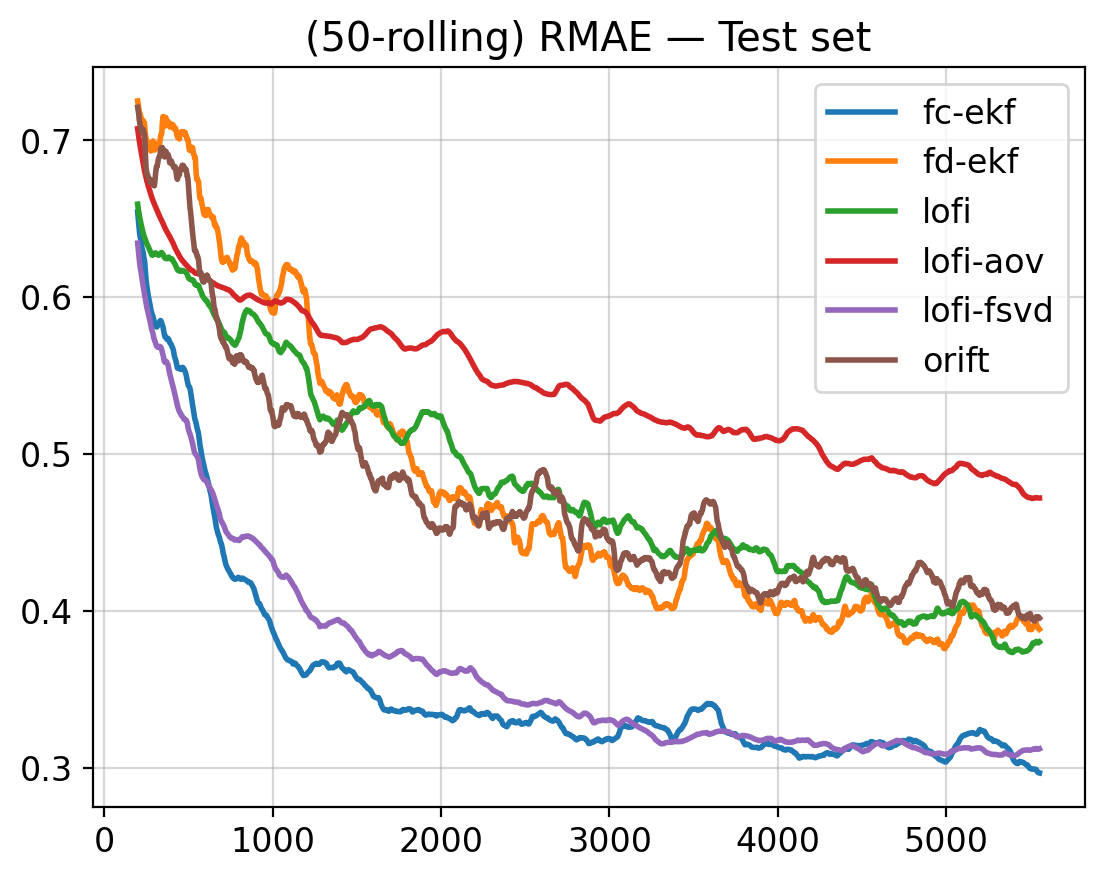

In [59]:
data.rolling(200).mean().plot()
plt.title(f"(50-rolling) RMAE — Test set")
plt.grid(alpha=0.5)

# Simulations

In [61]:
def eval_runs(key, num_runs_pc, estimator):
    num_devices = jax.device_count()
    num_sims = num_runs_pc * num_devices
    keys = jax.random.split(key, num_sims).reshape(-1, num_devices, 2)
    n_vals = len(X_learn)
    
    @partial(jax.pmap, in_axes=1)
    @partial(jax.vmap, in_axes=0)
    def evalf(key):
        key_shuffle, key_init = jax.random.split(key)
        ixs_shuffle = jax.random.choice(key, n_vals, (n_vals,), replace=False)
        
        params = model.init(key, jnp.ones((1, dim_in)))
        flat_params, _ = ravel_pytree(params)
        
        n_params = len(flat_params)

        bel, output = estimator.scan(
            X_learn[ixs_shuffle], y_learn[ixs_shuffle], callback=eval_callback, progress_bar=False, **test_kwargs
        )
        return output
    
    
    outputs = evalf(keys)
    outputs = jax.tree_map(lambda x: x.reshape(num_sims, -1), outputs)
    return outputs

In [62]:
def plot_sims(data, ax, color, label, rolling=100):
    data.mean(axis=1).rolling(rolling).mean().plot(ax=ax, label=label, color=color)
    sims = data.rolling(rolling).mean().values
    plt.plot(sims, c=color, alpha=0.07, linewidth=1)

In [63]:
def plot_bounds(data, ax, color, label, rolling=100):
    n_obs = len(data)
    xrange = np.arange(n_obs)
    data.mean(axis=1).rolling(rolling).mean().plot(ax=ax, label=label, color=color)
    
    sims = data.rolling(rolling).mean().values
    mean_sim = sims.mean(axis=1)
    std_sim = sims.std(axis=1)
    
    lbound = mean_sim - 2 * std_sim
    ubound = mean_sim + 2 * std_sim
    
    ax.fill_between(xrange, lbound, ubound, alpha=0.2, color=color)

## Run simulations

In [68]:
agents = {
    "lofi": lofi_estimator,
    "lofi-aov": lofi_aov_estimator,
    "lofi-fsvd": lofi_fsvd_estimator,
    "orfit": orfit_estimator,
    "fd-ekf": dekf_estimator,
    "fc-ekf": fcekf_estimator
}


sims = {}
n_agents = len(agents)
for name, agent in tqdm(agents.items(), total=n_agents):
    res = eval_runs(key, num_runs_pc=5, estimator=agent)
    sims[name] = jax.tree_map(np.array, res)

  0%|          | 0/6 [00:00<?, ?it/s]

In [69]:
jax.tree_map(np.shape, sims)

{'fc-ekf': {'osa-error': (40, 5554), 'test': (40, 5554)},
 'fd-ekf': {'osa-error': (40, 5554), 'test': (40, 5554)},
 'lofi': {'osa-error': (40, 5554), 'test': (40, 5554)},
 'lofi-aov': {'osa-error': (40, 5554), 'test': (40, 5554)},
 'lofi-fsvd': {'osa-error': (40, 5554), 'test': (40, 5554)},
 'orfit': {'osa-error': (40, 5554), 'test': (40, 5554)}}

## Plots

### Plot rolling RMAE on the test set

In [70]:
collection = {
    agent: pd.DataFrame(res["test"]).T
    for agent, res in sims.items()
}

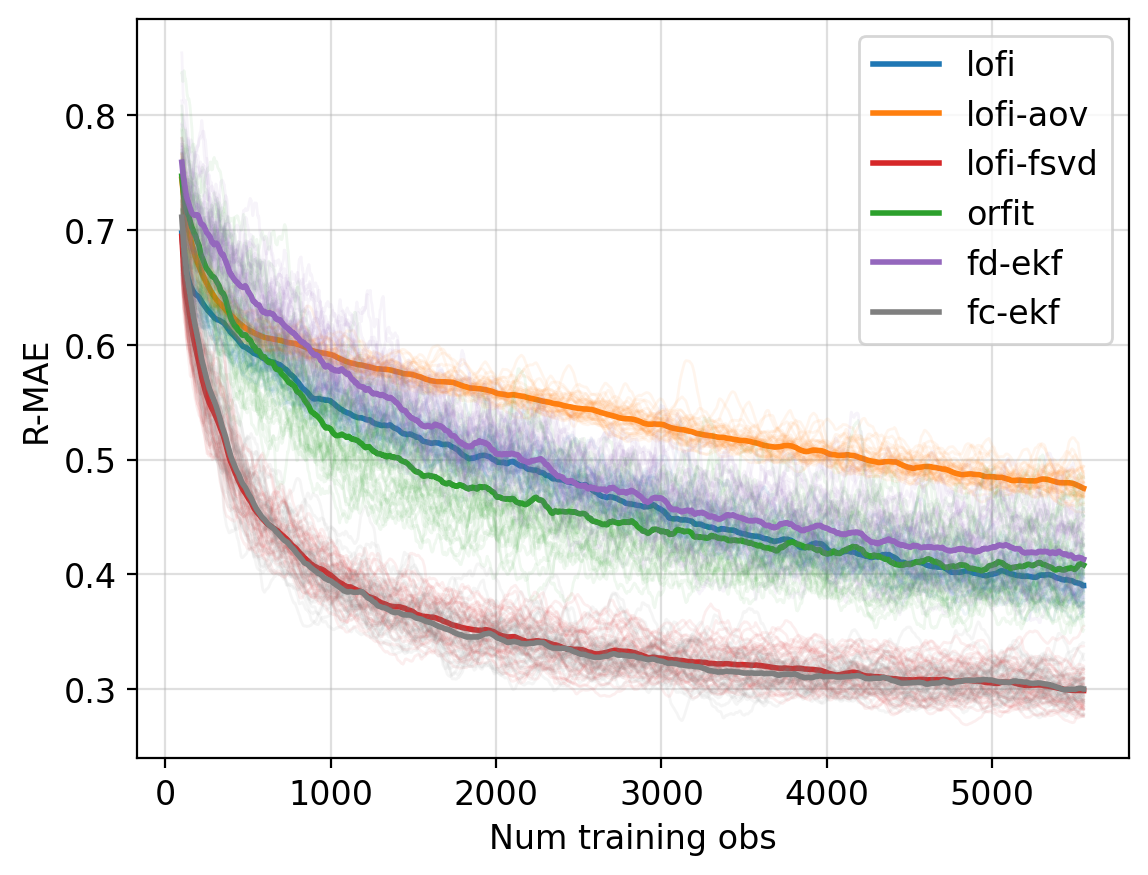

In [71]:
fig, ax = plt.subplots()

for label, data in collection.items():
    plot_sims(data, ax, colors[label], label)

plt.legend()
plt.grid(alpha=0.4)
plt.xlabel("Num training obs")
plt.ylabel("R-MAE")
plt.savefig(f"output/bounds-{dataset}.pdf")

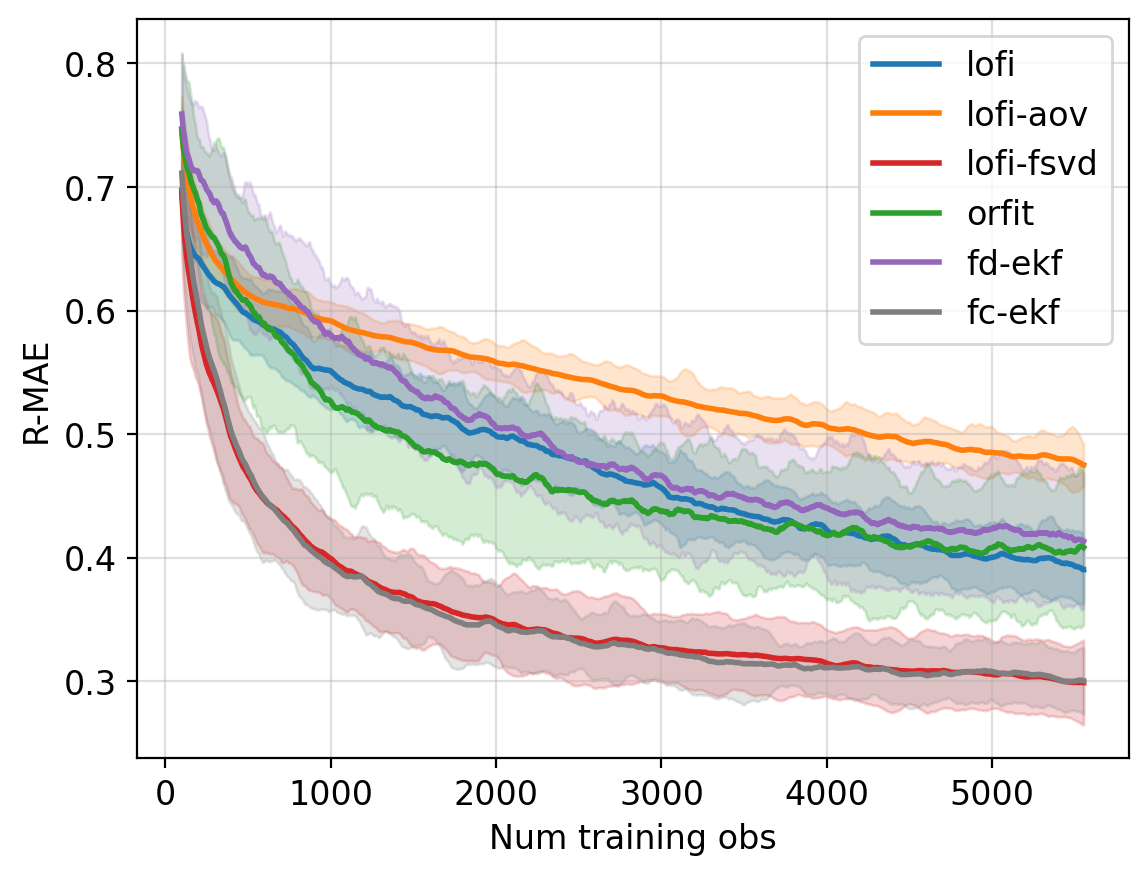

In [72]:
fig, ax = plt.subplots()

for label, data in collection.items():
    plot_bounds(data, ax, colors[label], label)

plt.legend()
plt.grid(alpha=0.4)
plt.xlabel("Num training obs")
plt.ylabel("R-MAE")
plt.savefig(f"output/sims-{dataset}.pdf")

In [73]:
last_rmae = {
    key: collection[key].iloc[-1]
    for key in collection
}
last_rmae = pd.DataFrame(last_rmae)

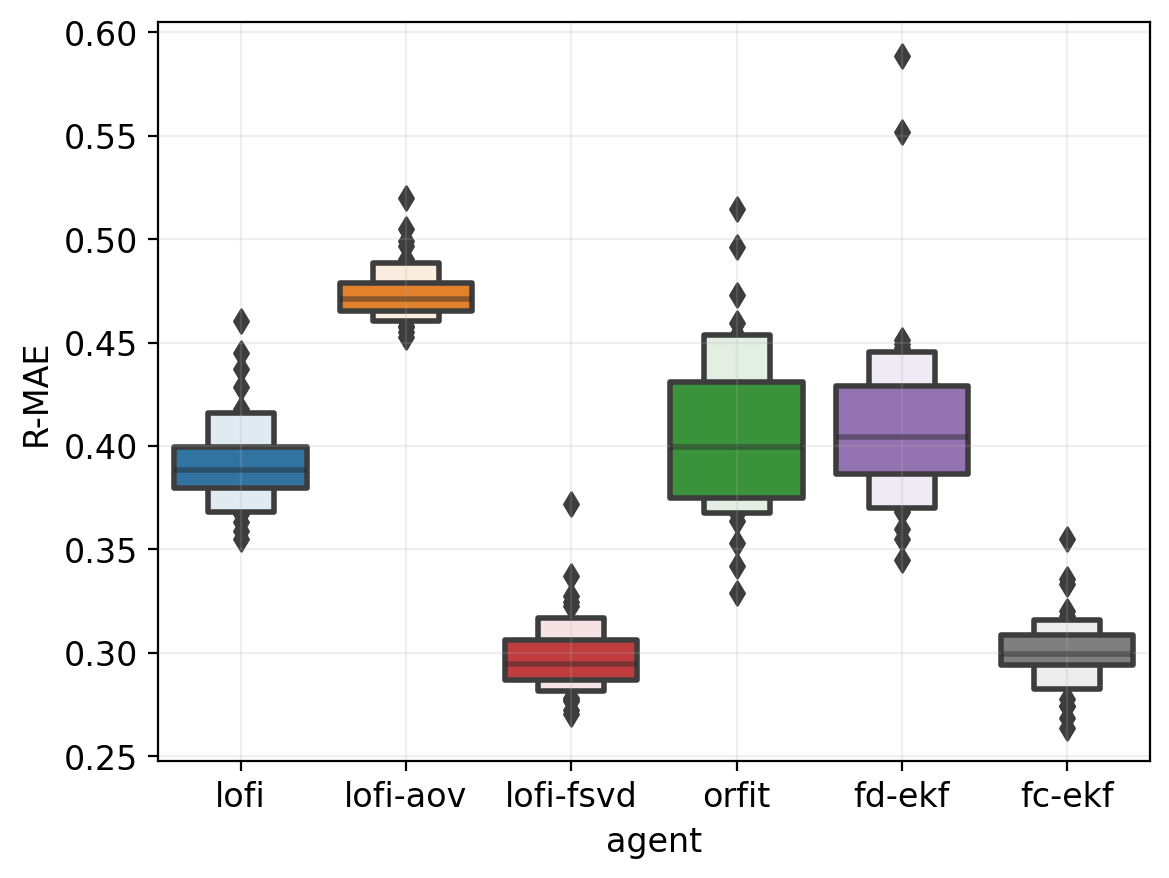

In [74]:
sns.boxenplot(
    x="agent",
    y="R-MAE",
    palette=colors,
    data=last_rmae.melt(var_name="agent", value_name="R-MAE")
)
plt.grid(alpha=0.2)
plt.savefig(f"output/last-metric-{dataset}.pdf")

### Plot rolling RMAE on the one-step-ahead posterior predictive

In [75]:
collection = {
    agent: pd.DataFrame(res["osa-error"]).T
    for agent, res in sims.items()
}

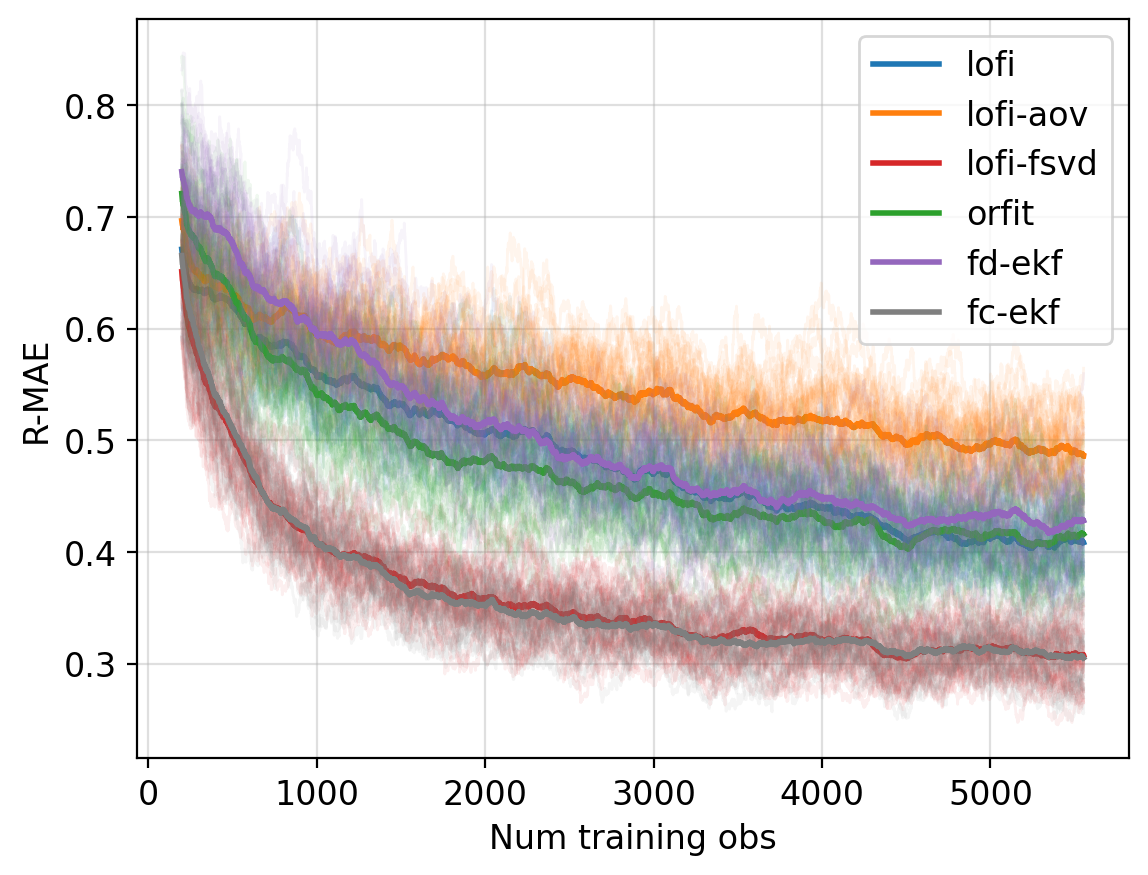

In [76]:
fig, ax = plt.subplots()

for label, data in collection.items():
    plot_sims(data, ax, colors[label], label, rolling=200)

plt.legend()
plt.grid(alpha=0.4)
plt.xlabel("Num training obs")
plt.ylabel("R-MAE")
plt.savefig(f"output/one-step-ahead-sims-{dataset}.pdf")

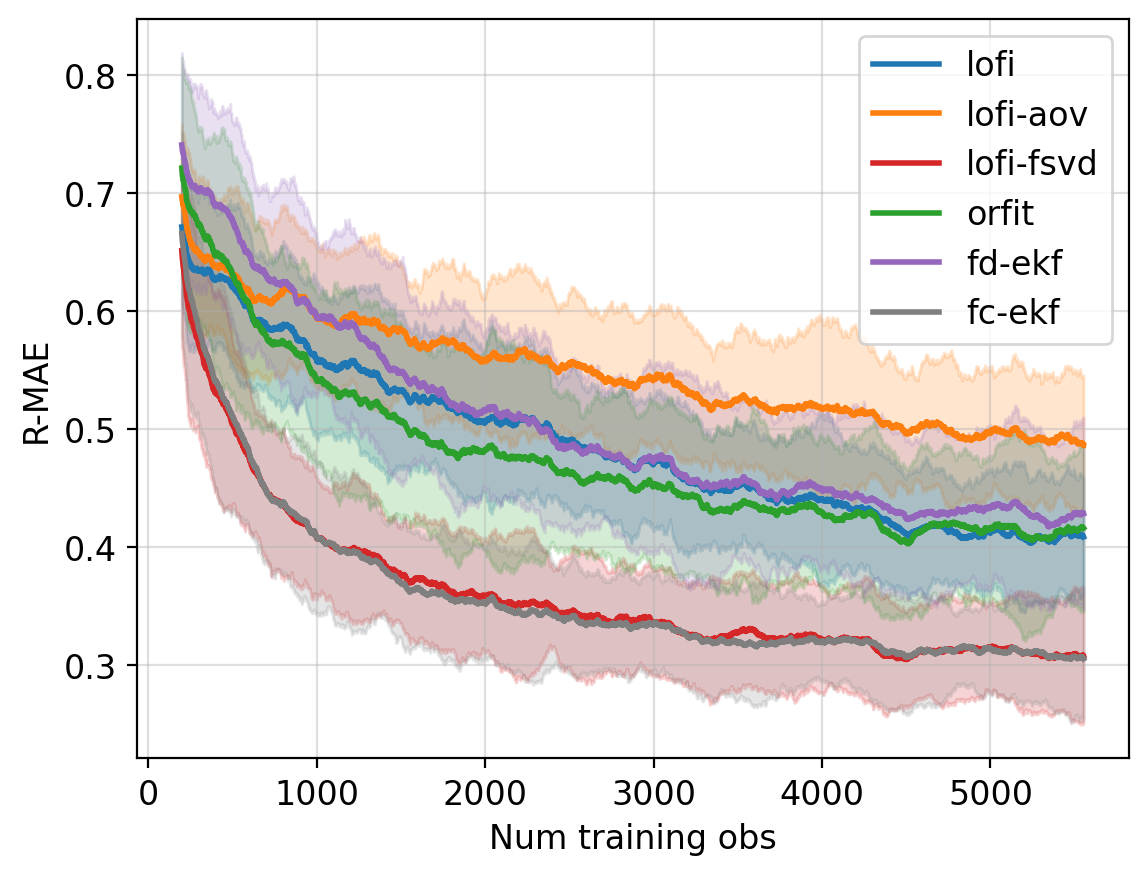

In [77]:
fig, ax = plt.subplots()

for label, data in collection.items():
    plot_bounds(data, ax, colors[label], label, rolling=200)

plt.legend()
plt.grid(alpha=0.4)
plt.xlabel("Num training obs")
plt.ylabel("R-MAE")
plt.savefig(f"output/one-step-ahead-bounds-{dataset}.pdf")